## Imports

In [1]:
%load_ext tensorboard
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import random
import h5py
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from datetime import datetime, timedelta 
from data_processing import LoadData #这里加载了一个数据处理的文件


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


# set manual seed for reproducibility
seed = 1001

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Tue Jun 08 15:58:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.50       Driver Version: 442.50       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX250      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Re-Format Time

In [2]:
def get_time_format(seconds):
    sec = timedelta(seconds=int(seconds))
    d = datetime(1, 1, 1) + sec
    if d.day-1 == 1:
        return "%.2d:%.2d:%.2d:%.2d" % (d.day-1, d.hour, d.minute, d.second)
    return "%.2d:%.2d:%.2d" % (d.hour, d.minute, d.second)


def calculate_time(start_time):
    return get_time_format(time.time() - start_time)

## Visualize Data

In [3]:
def get_flow(file_name): # 将读取文件写成一个函数
   
    flow_data = np.load(file_name) # 载入交通流量数据
    print([key for key in flow_data.keys()]) # 打印看看key是什么  
    print(flow_data["data"].shape)  # (16992, 307, 3)，16992是时间(59*24*12)，307是节点数，3表示每一维特征的维度（类似于二维的列）
    flow_data = flow_data['data'] # [T, N, D]，T为时间，N为节点数，D为节点特征
    return flow_data

['data']
(16992, 307, 3)
(16992, 307, 3)


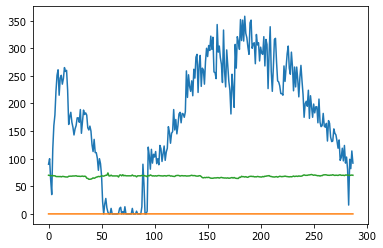

In [4]:
# traffic_data = get_flow("PeMS/PeMS08.npz")
# node_id = 10
# print(traffic_data.shape)
    
# plt.plot(traffic_data[:24*12, node_id, 0])  # 0维特征
# plt.savefig("asset/node_{:3d}_PEMS08_1.png".format(node_id))

# plt.plot(traffic_data[:24 * 12, node_id, 1])  # 1维特征
# plt.savefig("asset/node_{:3d}_PEMS08_2.png".format(node_id))

# plt.plot(traffic_data[:24 * 12, node_id, 2])  # 2维特征
# plt.savefig("asset/node_{:3d}_PEMS08_3.png".format(node_id))
    
traffic_data = get_flow("PeMS/PeMS04.npz")
node_id = 10
print(traffic_data.shape)
    
plt.plot(traffic_data[:24*12, node_id, 0])  # 0维特征
plt.savefig("asset/node_{:3d}_PEMS04_1.png".format(node_id))

plt.plot(traffic_data[:24 * 12, node_id, 1])  # 1维特征
plt.savefig("asset/node_{:3d}_PEMS04_2.png".format(node_id))

plt.plot(traffic_data[:24 * 12, node_id, 2])  # 2维特征
plt.savefig("asset/node_{:3d}_PEMS04_3.png".format(node_id))

## Load the PEMS Dataset

In [5]:
# Loading Dataset
train_data = LoadData(data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=10)
test_data = LoadData(data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=10)
print(len(train_data)) #整个train_data 有12954长度 每条数据的维度是[307, 6, 1] 标签的长度是[307, 1, 1]
print(len(test_data))
print(train_data[0]["flow_x"].size())
print(train_data[0]["flow_y"].size())


12954
4032
torch.Size([307, 6, 1])
torch.Size([307, 1, 1])


## visualize result and Evaluation

In [6]:
class Evaluation(object):
    def __init__(self):
        pass

    @staticmethod
    def mae_(target, output):
        return np.mean(np.abs(target - output))

    @staticmethod
    def mape_(target, output):
        return np.mean(np.abs(target - output) / (target + 5)) # 加５是因为target有可能为0，当然只要不太大，加几都行

    @staticmethod
    def rmse_(target, output):
        return np.sqrt(np.mean(np.power(target - output, 2)))

    @staticmethod
    def total(target, output):
        mae = Evaluation.mae_(target, output)
        mape = Evaluation.mape_(target, output)
        rmse = Evaluation.rmse_(target, output)

        return mae, mape, rmse

def visualize_result(h5_file, nodes_id, time_se, visualize_file):
    file_obj = h5py.File(h5_file, "r") # 获得文件对象，这个文件对象有两个keys："predict"和"target"
    prediction = file_obj["predict"][:][:, :, 0]  # [N, T],切片，最后一维取第0列，所以变成二维了，要是[:, :, :1]那么维度不会缩减
    target = file_obj["target"][:][:, :, 0]  # [N, T],同上
    file_obj.close()

    plot_prediction = prediction[nodes_id][time_se[0]: time_se[1]]  # [T1]，将指定节点的，指定时间的数据拿出来
    plot_target = target[nodes_id][time_se[0]: time_se[1]] # [T1]，同上

    plt.figure()
    plt.grid(True, linestyle="-.", linewidth=0.5)
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_prediction, ls="-", marker=" ", color="r")
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_target, ls="-", marker=" ", color="b")

    plt.legend(["prediction", "target"], loc="upper right")
    # plt.title('GAT_PEMS04_TFP')
#     plt.title('Cheb_PEMS04_TFP')
    plt.title('FedavgCheb_PEMS04_TFP')
#     plt.title('FedproxCheb_PEMS04_TFP')
    plt.xlabel("time")
    plt.ylabel("traffic flow")

    plt.axis([0, time_se[1] - time_se[0],
              np.min(np.array([np.min(plot_prediction), np.min(plot_target)])),
              np.max(np.array([np.max(plot_prediction), np.max(plot_target)]))])

    plt.savefig(visualize_file + ".png")

## create Model

In [7]:
# chebnet模型
import torch.nn.init as init
class ChebConv(nn.Module): # 定义图卷积层的类
    """
    The ChebNet convolution operation.

    :param in_c: int, number of input channels.
    :param out_c: int, number of output channels.
    :param K: int, Chebyshev多项式的阶数。
    """
    def __init__(self, in_c, out_c, K, bias=True, normalize=True):
        super(ChebConv, self).__init__()
        self.normalize = normalize # 正则化参数,True or False

        self.weight = nn.Parameter(torch.Tensor(K + 1, 1, in_c, out_c))  # [K+1, 1, in_c, out_c] ,第二个1是维度扩张，计算方便,有没有都不影响参数的大小,nn.Parameter就是把参数转换成模型可改动的参数.
        # 之所以要k+1,是因为k是从0开始的
        init.xavier_normal_(self.weight)  # 用正态分布填充

        if bias: # 偏置,就是一次函数中的b
            self.bias = nn.Parameter(torch.Tensor(1, 1, out_c))  # 前面的两个1是为了计算简单，因为输出的维度是3维
            init.zeros_(self.bias)  # 用0填充
        else:
            self.register_parameter("bias", None)

        self.K = K + 1

    def forward(self, inputs, graph):
        """
        :param inputs: the input data, [B, N, C]
        :param graph: the graph structure, [N, N]
        :return: convolution result, [B, N, D]
        """
        L = ChebConv.get_laplacian(graph, self.normalize)  # [N, N],得到拉普拉斯矩阵
        mul_L = self.cheb_polynomial(L).unsqueeze(1)   # [K, 1, N, N]，这个就是多阶的切比雪夫多项式，K就是阶数，N是节点数量

        result = torch.matmul(mul_L, inputs)  # [K, B, N, C]，这个就是计算完后乘x
        result = torch.matmul(result, self.weight)  # [K, B, N, D]，计算上一步之后乘W
        result = torch.sum(result, dim=0) + self.bias  # [B, N, D]，求和

        return result

    def cheb_polynomial(self, laplacian): # 计算切比雪夫多项式,也就是前面公式中的 T_k(L)
        """
        Compute the Chebyshev Polynomial, according to the graph laplacian.

        :param laplacian: the graph laplacian, [N, N].
        :return: the multi order Chebyshev laplacian, [K, N, N].
        """
        N = laplacian.size(0)  # [N, N] ,节点个数
        multi_order_laplacian = torch.zeros([self.K, N, N], device=laplacian.device, dtype=torch.float)  # [K, N, N],初始化一个全0的多项式拉普拉斯矩阵
        multi_order_laplacian[0] = torch.eye(N, device=laplacian.device, dtype=torch.float)  # 0阶的切比雪夫多项式为单位阵

        if self.K == 1: # 这个self.k就是前面说的0阶切比雪夫多项式
            return multi_order_laplacian
        else: # 大于等于1阶
            multi_order_laplacian[1] = laplacian
            if self.K == 2: # 1阶切比雪夫多项式就是拉普拉斯矩阵 L 本身
                return multi_order_laplacian
            else:
                for k in range(2, self.K):
                    multi_order_laplacian[k] = 2 * torch.mm(laplacian, multi_order_laplacian[k-1]) - \
                                               multi_order_laplacian[k-2] #切比雪夫多项式的递推式:T_k(L) = 2 * L * T_{k-1}(L) - T_{k-2}(L)

        return multi_order_laplacian

    @staticmethod
    def get_laplacian(graph, normalize): # 计算拉普拉斯矩阵
        """
        return the laplacian of the graph.

        :param graph: the graph structure without self loop, [N, N].
        :param normalize: whether to used the normalized laplacian.
        :return: graph laplacian.
        """
        if normalize:
            D = torch.diag(torch.sum(graph, dim=-1) ** (-1 / 2)) # 这里的graph就是邻接矩阵,这个D
            L = torch.eye(graph.size(0), device=graph.device, dtype=graph.dtype) - torch.mm(torch.mm(D, graph), D) # L = I - D * A * D,这个也就是正则化
        else:
            D = torch.diag(torch.sum(graph, dim=-1))
            L = D - graph
        return L


class ChebNet(nn.Module):  # 定义图网络的类
    def __init__(self, in_c, hid_c, out_c, K):
        """
        :param in_c: int, number of input channels.
        :param hid_c: int, number of hidden channels.class
        :param out_c: int, number of output channels.
        :param K:
        """
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(in_c=in_c, out_c=hid_c, K=K) # 第一个图卷积层
        self.conv2 = ChebConv(in_c=hid_c, out_c=out_c, K=K)  # 第二个图卷积层
        self.act = nn.ReLU() # 激活函数

    def forward(self, data, device):
        graph_data = data["graph"].to(device)[0]  # [N, N]
        flow_x = data["flow_x"].to(device)  # [B, N, H, D]  # B是batch size，N是节点数，H是历史数据长度，D是特征维度

        B, N = flow_x.size(0), flow_x.size(1) 

        flow_x = flow_x.view(B, N, -1)  # [B, N, H*D] H = 6, D = 1把最后两维缩减到一起了，这个就是把历史时间的特征放一起

        output_1 = self.act(self.conv1(flow_x, graph_data))
        output_2 = self.act(self.conv2(output_1, graph_data))

        return output_2.unsqueeze(2)  # 在第２维度，也就是时间维度上做扩张

### Print Model Summaries

In [8]:
# gcn = GCN(in_c=6, hid_c=6, out_c=1)
# gat = GATNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2)
cheb = ChebNet(in_c=6, hid_c=6, out_c=1, K=2)

device = torch.device("cpu")

cheb = cheb.to(device)

print("\nChebNET SUMMARY")
# print(summary(cheb, (307, 6, 1)))
print(cheb)


ChebNET SUMMARY
ChebNet(
  (conv1): ChebConv()
  (conv2): ChebConv()
  (act): ReLU()
)


## No fedprox Testing Loop

In [13]:
def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # 加载数据集
    train_data = LoadData(data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    test_data = LoadData(data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

    # 第二步：定义模型（这里其实只是加载模型，关于模型的定义在下面单独写了，先假设已经写好）
    my_net = ChebNet(in_c=6, hid_c=6, out_c=1, K=2)   # 加载ChebNet模型
    device = torch.device("cpu")
    my_net = my_net.to(device)

    # 第三步：定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params=my_net.parameters())
    
    # 第四步：训练+测试
    Epoch = 10
    my_net.train()
    for epoch in range(Epoch):
        epoch_loss = 0.0
        start_time = time.time()
        for data in train_loader:  # ["graph": [B, N, N] , "flow_x": [B, N, H, D], "flow_y": [B, N, 1, D]]
            my_net.zero_grad()  # 梯度清零
            predict_value = my_net(data, device).to(torch.device("cpu"))  # [0, 1] -> recover
            loss = criterion(predict_value, data["flow_y"]) # 计算损失，切记这个loss不是标量 [B, N, 1, D],由于标签flow_y在cpu中，所以最后的预测值要放回到cpu中
            epoch_loss += loss.item()
            loss.backward() # 反向传播
            optimizer.step() # 更新参数
        end_time = time.time()
        print("Epoch: {:04d}, Loss: {:02.4f}, Time: {:02.2f} mins".format(epoch, 1000 * epoch_loss / len(train_data),
                                                                          (end_time-start_time)/60))
    # Test Model
    # 对于测试:
    # 第一、除了计算loss之外，还需要可视化一下预测的结果（定性分析）
    # 第二、对于预测的结果这里我使用了 MAE, MAPE, and RMSE 这三种评价标准来评估（定量分析）
    my_net.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [], [], []
        Target = np.zeros([307, 1, 1]) # [N, T, D],T=1 ＃ 目标数据的维度，用０填充
        Predict = np.zeros_like(Target)  #[N, T, D],T=1 # 预测数据的维度

        total_loss = 0.0
        for data in test_loader: # 一次把一个batch的测试数据取出来

     # 下面得到的预测结果实际上是归一化的结果，有一个问题是我们这里使用的三种评价标准以及可视化结果要用的是逆归一化的数据
            predict_value = my_net(data, device).to(torch.device("cpu"))  # [B, N, 1, D]  -> [1, N, B(T), D]
            loss = criterion(predict_value, data["flow_y"])
            total_loss += loss.item() # 所有的batch的loss累加
            
     # 下面实际上是把预测值和目标值的batch放到第二维的时间维度，这是因为在测试数据的时候对样本没有shuffle，
     # 所以每一个batch取出来的数据就是按时间顺序来的，因此放到第二维来表示时间是合理的.
            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)

       #下面这个是每一个batch取出的数据，按batch这个维度进行串联，最后就得到了整个时间的数据，也就是
       # [N, T, D] = [N, T1+T2+..., D]
            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)
            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])
        print("Test Loss: {:02.4f}".format(1000 * total_loss / len(test_data)))

   # 三种指标取平均
    print("Performance:  MAE {:2.2f}    MAPE {:2.2f}%    RMSE {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))

    Predict = np.delete(Predict, 0, axis=1)
    Target = np.delete(Target, 0, axis=1)

    result_file = "asset/ChebNet_result04.h5"
    file_obj = h5py.File(result_file, "w")

    file_obj["predict"] = Predict
    file_obj["target"] = Target
    
    print (Predict)

In [14]:
def compute_performance(prediction, target, data):
    # 下面的try和except实际上在做这样一件事：当训练+测试模型的时候，数据肯定是经过dataloader的，所以直接赋值就可以了
    # 但是如果将训练好的模型保存下来，然后测试，那么数据就没有经过dataloader，是dataloader型的，需要转换成dataset型。
    try:
        dataset = data.dataset  # 数据为dataloader型，通过它下面的属性.dataset类变成dataset型数据
    except:
        dataset = data  # 数据为dataset型，直接赋值

   # 下面就是对预测和目标数据进行逆归一化，recover_data()函数在上一小节的数据处理中
   #  flow_norm为归一化的基，flow_norm[0]为最大值，flow_norm[1]为最小值
   # prediction.numpy()和target.numpy()是需要逆归一化的数据，转换成numpy型是因为 recover_data()函数中的数据都是numpy型，保持一致
    prediction = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], prediction.numpy())
    target = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], target.numpy())

   # 对三种评价指标写了一个类，这个类封装在另一个文件中 utils.py
    mae, mape, rmse = Evaluation.total(target.reshape(-1), prediction.reshape(-1))# 变成常向量才能计算这三种指标
    performance = [mae, mape, rmse]
    recovered_data = [prediction, target]

    return performance, recovered_data # 返回评价结果，以及恢复好的数据（为可视化准备的）

Epoch: 0000, Loss: 0.8670, Time: 0.41 mins
Epoch: 0001, Loss: 0.0676, Time: 0.32 mins
Epoch: 0002, Loss: 0.0548, Time: 0.42 mins
Epoch: 0003, Loss: 0.0504, Time: 0.33 mins
Epoch: 0004, Loss: 0.0486, Time: 0.33 mins
Epoch: 0005, Loss: 0.0476, Time: 0.40 mins
Epoch: 0006, Loss: 0.0470, Time: 0.38 mins
Epoch: 0007, Loss: 0.0466, Time: 0.38 mins
Epoch: 0008, Loss: 0.0464, Time: 0.41 mins
Epoch: 0009, Loss: 0.0461, Time: 0.40 mins
Test Loss: 0.0466
Performance:  MAE 18.66    MAPE 0.13%    RMSE 28.17
[[[ 82.54044399]
  [ 79.1043818 ]
  [ 64.62464289]
  ...
  [ 74.86989258]
  [ 69.81548899]
  [ 71.98693235]]

 [[ 58.90300828]
  [ 57.47463316]
  [ 56.92899173]
  ...
  [ 63.81640881]
  [ 64.55503267]
  [ 66.41782993]]

 [[ 74.23790127]
  [ 66.15328074]
  [ 62.67590404]
  ...
  [ 88.75985831]
  [ 85.28066218]
  [ 85.20565242]]

 ...

 [[ 80.38905501]
  [ 75.09311339]
  [ 66.55726594]
  ...
  [103.33268225]
  [ 96.10385633]
  [ 88.57250857]]

 [[ 58.65463853]
  [ 59.72098193]
  [ 61.13729548]
  .

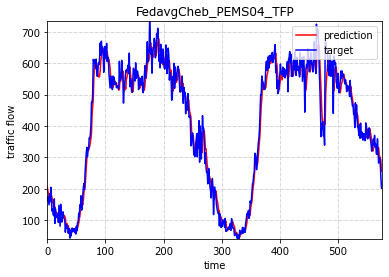

In [16]:
main()
visualize_result(h5_file="asset/ChebNet_result04.h5",
                     nodes_id=120, #取第120号节点
                     time_se=[0, 24 * 12 * 2],#时间从0-576
                     visualize_file="asset/chebnet_pems04_node_120")

## Partitioning the Data (IID and non-IID)

In [11]:
def iid_partition(dataset, clients):
  """
  I.I.D.在客户机上对数据进行分割。
  洗牌数据
  分给客户
  
  params.Dataset
    - 数据集(Torch.utils.Dataset)。包含MNIST图像的数据集
    - 客户端（int）。要分割数据的客户数量

  返回。
    - 每个客户的图像索引字典
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

## FedProx

### 系统异质性模拟

根据异质性所对应的设备百分比，为选定的客户机生成周期。

将x个周期数（在[1，E]之间统一随机选择）分别分配给0%、50%或90%的选定设备。0%的设备执行少于E个纪元的工作的设置对应于没有系统异质性的环境，而90%的设备发送其部分解决方案对应于高度异质的系统。

In [12]:
def GenerateLocalEpochs(percentage, size, max_epochs):
  ''' 
  该方法为选定的客户生成周期列表。
  复制系统的异质性
  Params:
    百分比：客户少于E时代的百分比。
    size: 列表的总大小
    max_epochs: 本地纪元的最大值。 
  返回。
    每个客户端更新的大小时间列表

  '''
  # 如果百分比为0，则每个客户端运行E个周期。
  if percentage == 0:
      return np.array([max_epochs]*size)
  else:
    # 得到的客户数量要少于E个周期
    heterogenous_size = int((percentage/100) * size)
    # 产生1到E之间的异质大小的随机统一周期。
    epoch_list = np.random.randint(1, max_epochs, heterogenous_size)
    # 其余的客户将有E个周期
    remaining_size = size - heterogenous_size
    rem_list = [max_epochs]*remaining_size
    epoch_list = np.append(epoch_list, rem_list, axis=0)
    # 洗牌并返回
    np.random.shuffle(epoch_list)
    return epoch_list

### 本地培训（客户端更新）

在客户端对模型进行本地培训


In [13]:
class CustomDataset(Dataset):
    def __init__(self, dataset,  idxs, num_nodes=307, divide_days=[45, 14], time_interval=5, history_length=6, train_mode='train'):
        """
        :param data_path: list, ["graph file name" , "flow data file name"], 保存数据文件名的路径。
        :param num_nodes: int, 节点的数量。
        :param divide_days: list, [ days of train data, days of test data], 分割原始数据的列表。
        :param time_interval: int, 两个交通数据记录之间的时间间隔（分钟）。
        :param history_length: int, 要使用的历史数据的长度。
        :param train_mode: list, ["train", "test"].
        """
        self.dataset = dataset
        self.idxs = list(idxs)
        self.num_nodes = num_nodes
        self.train_mode = train_mode
        self.train_days = divide_days[0]  # 45   59-14 = 45, train_data
        self.test_days = divide_days[1]  # 14  7*2 = 14 ,test_data
        self.history_length = history_length  # 6 30/5 = 6, 历史长度为6
        self.time_interval = time_interval  # 5 min
        self.one_day_length = int(24 * 60 / self.time_interval) # 一整天的数据量
        # self.graph = get_adjacent_matrix(distance_file=data_path[0], num_nodes=num_nodes)
        # self.flow_norm, self.flow_data = pre_process_data(data=get_flow_data(data_path[1]), norm_dim=1)# self.flow_norm为归一化的基
        # self.flow_data = self.dataset.flow_data
        # self.flow_norm = self.dataset.flow_norm
        # self.graph = self.dataset.graph

    def __len__(self):
        # if self.train_mode == "train":
        #     return self.train_days * self.one_day_length - self.history_length   #　每个样本都能测试，测试样本数　＝　测试总长度
        # elif self.train_mode == "test":
        #     return self.test_days * self.one_day_length  #　每个样本都能测试，测试样本数　＝　测试总长度
        # else:
        #     raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

        return len(self.idxs)

    def __getitem__(self, index):
        """
        :param index: int, range between [0, length - 1].
        :return:
            graph: torch.tensor, [N, N].
            data_x: torch.tensor, [N, H, D].
            data_y: torch.tensor, [N, 1, D].
        """
        # if self.train_mode == "train":
        #     index = index  #　训练集的数据是从时间０开始的，这个是每一个流量数据，要和样本（ｘ,y）区别
        # elif self.train_mode == "test":
        #     index += self.train_days * self.one_day_length #　有一个偏移量
        # else:
        #     raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

        a = self.idxs[index]
        self.flow_data = self.dataset[self.idxs[index]]
        # ['flow_data']
        data_x = self.flow_data['flow_x']
        data_y = self.flow_data['flow_y']
        graph = self.dataset[self.idxs[index]]['graph']
        # data_x, data_y = LoadData.slice_data(self.flow_data, self.history_length, index, self.train_mode)
        # data_x = LoadData.to_tensor(data_x)  # [N, H, D] # 转换成张量
        # data_y = LoadData.to_tensor(data_y).unsqueeze(1)  # [N, 1, D] 　# 转换成张量，在时间维度上扩维
        # return {"graph": LoadData.to_tensor(self.graph), "flow_x": data_x, "flow_y": data_y}  #组成词典返回
        return {"graph": graph, "flow_x": data_x, "flow_y": data_y}  #组成词典返回


    @staticmethod
    def pre_process_data(data, norm_dim):  # 预处理,归一化
        """
        :param data: np.array,原始的交通流量数据
        :param norm_dim: int, 归一化的维度，就是说在哪个维度上归一化,这里是在dim=1时间维度上
        :return:
            norm_base: list, [max_data, min_data], 这个是归一化的基.
            norm_data: np.array, normalized traffic data.
        """
        norm_base = LoadData.normalize_base(data, norm_dim)  #  计算 normalize basefind the normalize base
        norm_data = LoadData.normalize_data(norm_base[0], norm_base[1], data)  # # 归一化后的流量数据
        return norm_base, norm_data  #返回基是为了恢复数据做准备的


class ClientUpdate(object):
    def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, mu, algorithm, data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"],
                 num_nodes=307, divide_days=[45, 14], time_interval=5, history_length=6, train_mode='train'):
        # self.train_loader = DataLoader(CustomDataset(data_path, num_nodes, divide_days, time_interval, history_length, train_mode),
        #                                batch_size=batchSize, shuffle=True)
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
        # self.train_loader = DataLoader(dataset,
        #                                batch_size=batchSize, shuffle=True)
        self.algorithm = algorithm
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.my_net = ChebNet(in_c=6, hid_c=6, out_c=1, K=2)

    def train(self, model):
        # print("Client training for {} epochs.".format(self.epochs))
        criterion = nn.CrossEntropyLoss()
        proximal_criterion = nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
        # 利用全局模型的权重进行近端项计算。
        global_model = copy.deepcopy(model)
        # 计算本地训练时间
        start_time = time.time()
        e_loss = []
        for epoch in range(1, self.epochs+1):
            train_loss = 0.0
            model.train()
            for data in self.train_loader:
                # if torch.cuda.is_available():
                #     data = data.cuda()
                # 清除梯度
                optimizer.zero_grad()
                # 做反向传播
                predict_value = self.my_net(data, device).to(torch.device("cpu"))  # [0, 1] -> recover
                # calculate the loss + the proximal term
                #         _, pred = torch.max(output, 1)
                pre = predict_value
                tru = data["flow_y"]
                if self.algorithm == 'fedprox':
                    proximal_term = 0.0
                    #迭代当前和全局模型参数
                    for w, w_t in zip(model.parameters(), global_model.parameters()) :
                        # 更新近端项常数
                        #proximal_term += torch.sum(torch.abs((w-w_t)**2))
                        proximal_term += (w-w_t).norm(2)
                    loss = proximal_criterion(pre,  tru) + (mu/2)*proximal_term
                else:
                    loss = proximal_criterion(pre,  tru) # 计算损失，切记这个loss不是标量 [B, N, 1, D],由于标签flow_y在cpu中，所以最后的预测值要放回到cpu中
                # 做反向传播
                loss.backward()
                # 执行单一的优化步骤
                optimizer.step()
                # 更新损失函数
                train_loss += loss.item()*data["flow_y"].shape[0]
                # 平均损失
            train_loss = train_loss/len(self.train_loader.dataset)
            e_loss.append(train_loss)
            # print('epoch: ', epoch, 'train_loss: ',train_loss)

        total_loss = sum(e_loss)/len(e_loss)

        return model.state_dict(), total_loss, (time.time() - start_time)


### 服务器端的培训和训练



In [14]:
def testing(model, test_data, bs, criterion):
   
    criterion = nn.MSELoss()
    test_loss = 0.0
    test_loader = DataLoader(test_data, batch_size=bs, shuffle=False, num_workers=0)
    l = len(test_loader)
    model.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [], [], []
        Target = np.zeros([307, 1, 1]) # [N, T, D],T=1 ＃ 目标数据的维度，用０填充
        Predict = np.zeros_like(Target)  #[N, T, D],T=1 # 预测数据的维度
        total_loss = 0.0
        for data in test_loader: # 一次把一个batch的测试数据取出来
            # if torch.cuda.is_available():
            #     data = data.cuda()
            predict_value = model(data, device).to(torch.device("cpu"))  # [B, N, 1, D]  -> [1, N, B(T), D]
            loss = criterion(predict_value, data["flow_y"])
            total_loss += loss.item() # 所有的batch的loss累加

            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)

            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)
            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])
        # 平均测试损失
        test_loss = total_loss/len(test_data)
        # print("Test Loss: {:.6f}\n".format(test_loss))

        Predict = np.delete(Predict, 0, axis=1)
        Target = np.delete(Target, 0, axis=1)
        
        
        result_file = "asset/FedavgCheb_result04.h5"
#         result_file = "asset/FedproxCheb_result04.h5"
        file_obj = h5py.File(result_file, "w")
    
        file_obj["predict"] = Predict
        file_obj["target"] = Target
    
    return test_loss,MAE,MAPE,RMSE

In [15]:
def training(model, rounds, batch_size, lr, train_data, data_dict, test_data, C, K, E, mu, percentage, plt_title, plt_color, algorithm):
    """
    函数实现了FedAvg论文中的Federated Averaging算法。
    具体来说，这个函数用于服务器端的训练和权重更新参数。
      - model。          要训练的PyTorch模型
      - rounds。         客户端更新的通信轮次
      - batch_size:      客户更新培训的批次大小
      - lr:              用于客户更新培训的学习率
      - train_data:              用于训练的数据集
      - data_dict：用于训练的数据分区类型（IID或非IID）。
      - test_data:  用于测试模型的数据
      - C：每轮随机选取进行计算的客户的分数
      - K：客户总数
      - E：每个客户端每轮对其本地数据集的训练次数。
      - mu：近端项常数
      - percentage：所选客户中E次以下的百分比
    返回。
      - model: 在服务器上训练的模型
    """
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    data_path=["PeMS/PeMS04.csv", "PeMS/PeMS04.npz"]
    # 加载数据
    train_data = LoadData(data_path, num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    test_data = LoadData(data_path, num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

    # 全局模型权重
    global_weights = model.state_dict()
    train_loss = []
    test_acc = []
    # 储存最后的损失，用于收敛
    last_loss = 0.0
    total_time = 0

    print(f"System heterogeneity set to {percentage}% stragglers.\n")
    print(f"Picking {max(int(C*K),1 )} random clients per round.\n")

    for curr_round in range(1, rounds+1):
        w, local_loss, lst_local_train_time = [], [], []
        m = max(int(C*K), 1)
        heterogenous_epoch_list = GenerateLocalEpochs(percentage, size=m, max_epochs=E)
        heterogenous_epoch_list = np.array(heterogenous_epoch_list)
        S_t = np.random.choice(range(K), m, replace=False)
        S_t = np.array(S_t)

        # 对于联合平均，放弃所有的散兵游勇的客户。
        if algorithm == 'fedavg':
            stragglers_indices = np.argwhere(heterogenous_epoch_list < E)
            heterogenous_epoch_list = np.delete(heterogenous_epoch_list, stragglers_indices)
            S_t = np.delete(S_t, stragglers_indices)

        for k, epoch in zip(S_t, heterogenous_epoch_list):
            local_update = ClientUpdate(dataset=train_data, batchSize=batch_size, learning_rate=lr, epochs=epoch, idxs=data_dict[k], mu=mu, algorithm=algorithm)
            weights, loss, local_train_time = local_update.train(model=copy.deepcopy(model))
            print('epochs: ', epoch, 'loss: ', loss)

            w.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))
            lst_local_train_time.append(local_train_time)

        # 计算更新全局权重的时间
        global_start_time = time.time()

        # 更新全局权重
        weights_avg = copy.deepcopy(w[0])
        for k in weights_avg.keys():
            for i in range(1, len(w)):
                weights_avg[k] += w[i][k]
            weights_avg[k] = torch.div(weights_avg[k], len(w))

        global_weights = weights_avg
        global_end_time = time.time()

        # 计算总时间
        total_time += (global_end_time - global_start_time) + sum(lst_local_train_time)/len(lst_local_train_time)
        # 将更新后的权重移到我们的模型状态下。
        model.load_state_dict(global_weights)
        loss_avg = sum(local_loss) / len(local_loss)

        # 测试性能
        criterion = nn.MSELoss()
        test_loss, MAE,MAPE,RMSE = testing(model, test_data, 128, criterion)
        print(f"Round: {curr_round}... \tAverage Train Loss: {round(loss_avg, 3)}... \tTest Loss: {test_loss}")
        print("Performance:  MAE {:2.2f}    MAPE {:2.2f}%    RMSE {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))
        train_loss.append(loss_avg)  
        
         # 如果我们实现了收敛，即连续两轮之间的损失<0.0001，就会中断。
        if algorithm == 'fedprox' and abs(loss_avg - last_loss) < 0.0001:
            rounds = curr_round
            break
        # 更新最后的损失
        last_loss = loss_avg

    #  画出训练损失
    fig, ax = plt.subplots()
    x_axis = np.arange(1, rounds+1)
    y_axis = np.array(train_loss)
    ax.plot(x_axis, y_axis)

    ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
           title=plt_title)
    ax.grid()
    fig.savefig(plt_title+'.jpg', format='jpg')
#     visualize_result(h5_file="asset/FedavgCheb_result04.h5",
#                      nodes_id=120, #取第120号节点
#                      time_se=[0, 24 * 12 * 2],#时间从0-576
#                      visualize_file="asset/fedavgcheb_pems04_node_120")

    print("Training Done!")
    # print("Total time taken to Train: {}".format(get_time_format(total_time)))

    return model

## Special Case of FedProx with mu = 0 where it is Federated Averaging FedProx的特殊情况，mu=0，其中是联邦平均法。

# 与联邦平均IID分区比较。

> 在一个高度异质的系统（90%）中，与Federated Averaging相比，FedProx的损失降低了很多。

通过上面的第一个测试，我们知道，在**mu=0**的特殊情况下，FedProx与FedAvg的结果相匹配。

我们将采用同样的思路，但这次要增加我们的杂散人员。我们将在**mu>0**的情况下进行同样的试验，比较FedProx的结果。

### Training Federated Averaging with 90% stragglers (IID Partition)

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

epochs:  50 loss:  0.20158534091572428
Round: 1... 	Average Train Loss: 0.202... 	Test Loss: 0.0018178775919497842
Performance:  MAE 204.33    MAPE 0.85%    RMSE 249.99
epochs:  50 loss:  0.1641879613235477
Round: 2... 	Average Train Loss: 0.164... 	Test Loss: 0.0018178775919497842
Performance:  MAE 204.33    MAPE 0.85%    RMSE 249.99
epochs:  50 loss:  0.20967970285189239
Round: 3... 	Average Train Loss: 0.21... 	Test Loss: 0.0018178775919497842
Performance:  MAE 204.33    MAPE 0.85%    RMSE 249.99
epochs:  50 loss:  0.15739794347752897
Round: 4... 	Average Train Loss: 0.157... 	Test Loss: 0.0018178775919497842
Performance:  MAE 204.33    MAPE 0.85%    RMSE 249.99
epochs:  50 loss:  0.13624735435889676
Round: 5... 	Average Train Loss: 0.136... 	Test Loss: 0.0018178775919497842
Performance:  MAE 204.33    MAPE 0.85%    RMSE 249.99
epochs:  50 loss:  0.20826398968465568
Round: 6... 	Average Train Loss: 0.

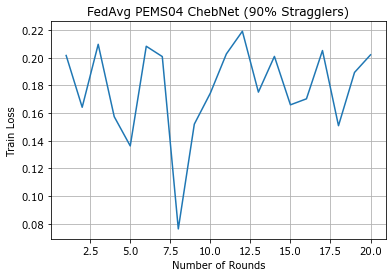

In [16]:
# 客户端更新的通信轮次
rounds = 20
# 每轮随机选取进行计算的客户的分数
C = 0.1
# 客户总数
K = 100
# 每个客户端每轮对其本地数据集的训练次数。
E = 50
# 客户更新培训的批次大小
batch_size = 10
# learning Rate
lr=0.01
#近端项常数
mu = 0.0
# 少于E周期数的客户百分比
percentage = 90
# # 目标测试精度
# target_test_accuracy=99.0
# 用于训练的数据分区类型（IID或非IID）。
iid_dict = iid_partition(train_data, 100)
# 加载模型
cheb = ChebNet(in_c=6, hid_c=6, out_c=1, K=2)

# if torch.cuda.is_available():
#   gcn.cuda()

pems04_cheb_iid_trained_fedavg = training(cheb, rounds, batch_size, lr, train_data, iid_dict, test_data, C, K, E, mu, percentage, "FedAvg PEMS04 ChebNet (90% Stragglers)", "orange", algorithm='fedavg')
 # 画出预测与目标对比图



### Training FedProx with 90% Stragglers (IID Parition)

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

epochs:  38 loss:  0.13926924658564585
epochs:  50 loss:  0.14900015788946963
epochs:  17 loss:  0.1804834939590394
epochs:  12 loss:  0.19175410038702556
epochs:  25 loss:  0.2338302036542301
epochs:  16 loss:  0.20742532722074392
epochs:  33 loss:  0.18938109965455452
epochs:  46 loss:  0.1628121379744054
epochs:  10 loss:  0.13424855134514874
epochs:  39 loss:  0.22472763022426767
Round: 1... 	Average Train Loss: 0.181... 	Test Loss: 0.0010456520429302362
Performance:  MAE 144.48    MAPE 0.65%    RMSE 189.12
epochs:  28 loss:  0.144422300925204
epochs:  17 loss:  0.22906830318092045
epochs:  35 loss:  0.20034767875771714
epochs:  24 loss:  0.2217935910953801
epochs:  47 loss:  0.22666511237473846
epochs:  43 loss:  0.19994444536807107
epochs:  40 loss:  0.2270824912502322
epochs:  50 loss:  0.14888431168919383
epochs:  27 loss:  0.19834465378836047
epochs:  29 loss:  0.1890167532893497
Round: 2... 	Av

epochs:  50 loss:  0.15213248546386876
epochs:  38 loss:  0.17001737957278448
epochs:  48 loss:  0.1869939443587929
epochs:  1 loss:  0.18328409162602682
epochs:  13 loss:  0.22640608404815799
epochs:  35 loss:  0.18381513456173518
epochs:  16 loss:  0.21901743187634062
epochs:  4 loss:  0.17490824866433474
epochs:  44 loss:  0.09210656167659712
epochs:  11 loss:  0.17290109771922746
Round: 17... 	Average Train Loss: 0.176... 	Test Loss: 0.00104565207896355
Performance:  MAE 144.48    MAPE 0.65%    RMSE 189.12
epochs:  30 loss:  0.1945168185584459
epochs:  50 loss:  0.21417305319808247
epochs:  4 loss:  0.0549087455106336
epochs:  28 loss:  0.08336264596259838
epochs:  41 loss:  0.12792445745232497
epochs:  2 loss:  0.35504937189262964
epochs:  32 loss:  0.17460244995281965
epochs:  43 loss:  0.21402396969275575
epochs:  17 loss:  0.18764969061022202
epochs:  26 loss:  0.14282671328618476
Round: 18... 	Average Train Loss: 0.175... 	Test Loss: 0.00104565207896355
Performance:  MAE 144.4

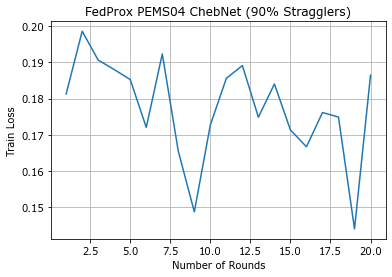

In [23]:
# 客户端更新的通信轮次
rounds = 20
#每轮随机选取进行计算的客户的分数
C = 0.1
# 客户总数
K = 100
#每个客户端每轮对其本地数据集的训练次数。
E = 50
# 客户更新培训的批次大小
batch_size = 10
# learning Rate
lr=0.01
# 近端项常数
mu = 0.01
# 少于E周期的客户百分比
percentage = 90
# target test accuracy
# target_test_accuracy = 99.0

# 用于训练的数据分区类型（IID或非IID）。
iid_dict = iid_partition(train_data, 100)
# load model
cheb = ChebNet(in_c=6, hid_c=6, out_c=1, K=2)

# if torch.cuda.is_available():
#    cheb.cuda()

pems_cheb_iid_trained_fedprox = training(cheb, rounds, batch_size, lr, train_data, iid_dict, test_data, C, K, E, mu, percentage, "FedProx PEMS04 ChebNet (90% Stragglers)", "green", algorithm='fedprox')